In [1]:
import numpy as np
import pandas as pd
import csv
import torch
import pandas as pd
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

df = pd.read_csv('/mnt/blossom/more/pbansal/dataset/jantahack/train.csv')

In [2]:
week_mapping = dict({})
for i,x in enumerate(df.week.unique()):
    week_mapping[x] = i
store_mapping = dict({})
for i,x in enumerate(df.store_id.unique()):
    store_mapping[x] = i
sku_mapping = dict({})
for i,x in enumerate(df.sku_id.unique()):
    sku_mapping[x] = i
df['encoded_week'] = df.apply(lambda x : week_mapping[x['week']],axis=1)
df['encoded_store'] = df.apply(lambda x : store_mapping[x['store_id']],axis=1)
df['encoded_sku'] = df.apply(lambda x : sku_mapping[x['sku_id']],axis=1)
data = df[["encoded_week","encoded_store","encoded_sku","units_sold"]]

In [3]:
out_array = np.zeros((130,76,28)).astype(np.float32)
for x in df.iterrows():
    out_array[x[1]['encoded_week'],x[1]['encoded_store'],x[1]['encoded_sku']] = x[1]['units_sold']

In [4]:
row_sums = np.std(out_array,axis=0,keepdims=True)
row_sums[row_sums==0] = 1
norm_out_array = out_array / row_sums
np.save('dataset/jantahack_noshift_numpy_complete',norm_out_array)

In [5]:
all_examples = data.loc[(data['encoded_week'] < 128) & (data['encoded_week'] > 1)].to_numpy()
np.random.shuffle(all_examples)
np.save('dataset/jantahack_test_examples.npy',all_examples[int(2*all_examples.shape[0]/3):])
np.save('dataset/jantahack_train_examples.npy',all_examples[:int(2*all_examples.shape[0]/3)])

In [6]:
def test_ (model,val_set):
    device = torch.device('cuda:1')
    batch_size = 64
    preds = []
    val_loader = torch.utils.data.DataLoader(val_set,shuffle=True,batch_size = batch_size,drop_last=False)
    model = model.to(device)
    loss_ = 0
    for x,y,index in val_loader :
        with torch.no_grad():
            x = x.to(device)
            y_pred,var = model(x)
            y = y.to(device)
            pred = ((y_pred-y)**2)/var + var
            loss_ +=  pred.mean().data*x.shape[0]
            pred = torch.exp(-0.5*pred).data
            for i in range(x.shape[0]):
                preds.append(((int(index[0][i]),int(index[1][i]),int(index[2][i])),float(pred[i]),float(var[i]),float(y_pred[i]),x[i].cpu()))
    loss_ = loss_/int(len(val_set))
    return loss_,np.array(preds)

In [7]:
import helper
import importlib
importlib.reload(helper)
val_set = helper.Dataset_('dataset/jantahack_noshift_numpy_complete.npy','dataset/jantahack_test_examples.npy')
epoch = 35
model = helper.NN()
model.load_state_dict(torch.load('/mnt/blossom/more/pbansal/janta_checkpoints/checkpoint_%d'%epoch))
_,truly_inlier_scores = test_(model,val_set)

loading dataset


/mnt/a99/d0/pbansal/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


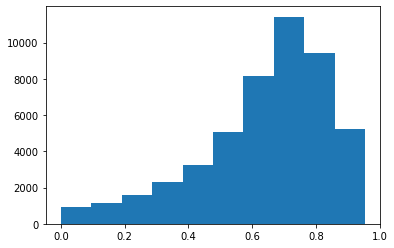

In [8]:
plt.hist(truly_inlier_scores[:,1])
temp = truly_inlier_scores[np.argsort(truly_inlier_scores[:,1])]
complete = np.load('dataset/jantahack_noshift_numpy_complete.npy')

In [13]:
i = 3
print(temp[i])
visualise(temp[i][0],temp[i][1],complete)

[(70, 54, 1) 2.220618995352197e-07 0.6578185558319092 2.3382489681243896
 tensor([ 2.5205,  2.2163,  1.7383,  1.7817,  0.1653,  0.1822,  0.4042,  0.3176,
         0.0466, -0.4794,  0.1643,  0.1081,  0.6913,  0.5814,  0.8831,  0.9774,
         0.7390,  0.8429,  0.6746,  0.7643])]
Index is :  (70, 54, 1)
True Value : 156, Normalised Value : 6.779335, Inlier Prob : 0.000000
Time Series Values : 
[1.1298891  2.1294065  4.2153554  2.4336073  2.5639791  1.6079191
 1.9555773  2.9985518  2.2597783  1.9555773  1.6948336  0.9126027
 2.39015    1.8252054  1.1733464  1.1733464  1.43409    0.95606
 1.7382909  1.1733464  2.1728637  1.6513764  1.6513764  1.3037182
 1.1298891  0.95606    1.3471755  1.5644618  1.7817482  1.1298891
 0.86914545 0.99951726 1.7817482  1.7817482  1.2602609  3.7807827
 1.5644618  1.3037182  1.5644618  1.2168037  1.7382909  1.6948336
 2.6508937  2.1294065  2.085949   2.216321   2.216321   6.084018
 4.432642   5.388702   2.694351   4.9975863  4.5195565  1.4775473
 1.43409    2

,encoded_week,encoded_store,encoded_sku,units_sold
829,0,54,1,26
1984,1,54,1,49
3139,2,54,1,97
4294,3,54,1,56
5449,4,54,1,59
6604,5,54,1,37
7759,6,54,1,45
8914,7,54,1,69
10069,8,54,1,52
11224,9,54,1,45


In [9]:
def visualise(index,pred,norm_out_array):
    print ("Index is : ",index)
    true_value = int(data.loc[(data["encoded_week"] == index[0]) & (data["encoded_store"] == index[1]) & (data["encoded_sku"] == index[2])]['units_sold'])
    time_series_value = norm_out_array[:,index[1],index[2]]
    normalised_value = time_series_value[index[0]]
    print ("True Value : %d, Normalised Value : %f, Inlier Prob : %f"%(true_value,normalised_value,pred))
    print ("Time Series Values : ")
    print (time_series_value)
    print ("Relaxing Time : ")
    pd.set_option('display.max_rows', None)
    display (data.loc[(data["encoded_store"] == index[1]) & (data["encoded_sku"] == index[2])])
    